<a href="https://colab.research.google.com/github/arunangshu19/PINN/blob/schrodinger/Schrondinger_avg_loss_n%3D1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
from scipy.special import hermite, factorial
import matplotlib.pyplot as plt

def psi_true_n(x, n):
    Hn = hermite(n)
    norm = 1.0 / np.sqrt(2.0**n * factorial(n) * np.sqrt(np.pi))
    return norm * np.exp(-x**2 / 2) * Hn(x)

In [8]:
import torch
import torch.nn as nn

class SchrodingerPINN(nn.Module):
    def __init__(self, hidden_dim=50, hidden_layers=3):
        super().__init__()
        layers = [nn.Linear(1, hidden_dim), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers += [nn.Linear(hidden_dim, 1)]
        self.net = nn.Sequential(*layers)
        self.E = nn.Parameter(torch.tensor(1.0))  # learnable energy

    def forward(self, x):
        return self.net(x)

In [9]:
def train_pinn(domain, model, N_colloc, epochs, lr=1e-3, device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    x_colloc = torch.linspace(domain[0], domain[1], N_colloc, device=device).view(-1, 1)
    x_colloc.requires_grad_(True)
    dx = (domain[1] - domain[0]) / N_colloc
    V = lambda x: 0.5 * x**2  # harmonic oscillator

    x_bc = torch.tensor([[domain[0]], [domain[1]]], device=device)

    loss_history = []
    for _ in range(epochs):
        optimizer.zero_grad()
        psi = model(x_colloc)
        psi_x = torch.autograd.grad(psi, x_colloc, torch.ones_like(psi), create_graph=True)[0]
        psi_xx = torch.autograd.grad(psi_x, x_colloc, torch.ones_like(psi_x), create_graph=True)[0]

        residual = psi_xx + 2 * (model.E - V(x_colloc)) * psi
        loss_pde = torch.mean(residual**2)
        loss_bc = torch.mean(model(x_bc)**2)
        norm = torch.sum(psi**2) * dx
        loss_norm = (norm - 1.0)**2
        loss_sign = torch.relu(-model(torch.tensor([[0.0]], device=device)))

        loss = loss_pde + loss_bc + loss_norm + loss_sign
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    return loss_history, model

In [10]:
def multi_run_plot(runs=5, epochs=5000, N_colloc=1000, L=3.0, seed_base=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_losses = []
    domain = [-L, L]

    for i in range(runs):
        torch.manual_seed(seed_base + i)
        np.random.seed(seed_base + i)

        model = SchrodingerPINN().to(device)
        loss, _ = train_pinn(domain, model, N_colloc, epochs, device=device)
        all_losses.append(loss)

    all_losses = np.array(all_losses)
    mean_loss = np.mean(all_losses, axis=0)
    std_loss = np.std(all_losses, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_loss, label='Mean Loss', color='blue')
    plt.fill_between(np.arange(epochs), mean_loss - std_loss, mean_loss + std_loss,
                     color='blue', alpha=0.3, label='±1 Std. Dev.')
    plt.yscale('log')
    plt.xlabel("Epoch")
    plt.ylabel("Loss (log)")
    plt.title(f"Average Loss over {runs} runs")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

In [13]:
def compare_wavefunction(model, L=3.0, n=1):
    model.eval()
    device = next(model.parameters()).device  # Detect model's device
    x = torch.linspace(-L, L, 500, device=device).unsqueeze(1)

    with torch.no_grad():
        pred = model(x).cpu().numpy()

    x_np = x.cpu().numpy().flatten()
    true = psi_true_n(x_np, n)

    plt.figure(figsize=(8, 5))
    plt.plot(x_np, pred, label='PINN solution')
    plt.plot(x_np, true, '--', label=f'True solution n={n}')
    plt.title(f'Wavefunction Comparison, Learned E = {model.E.item():.6f}')
    plt.xlabel("x")
    plt.ylabel("ψ(x)")
    plt.legend()
    plt.grid(True)
    plt.show()

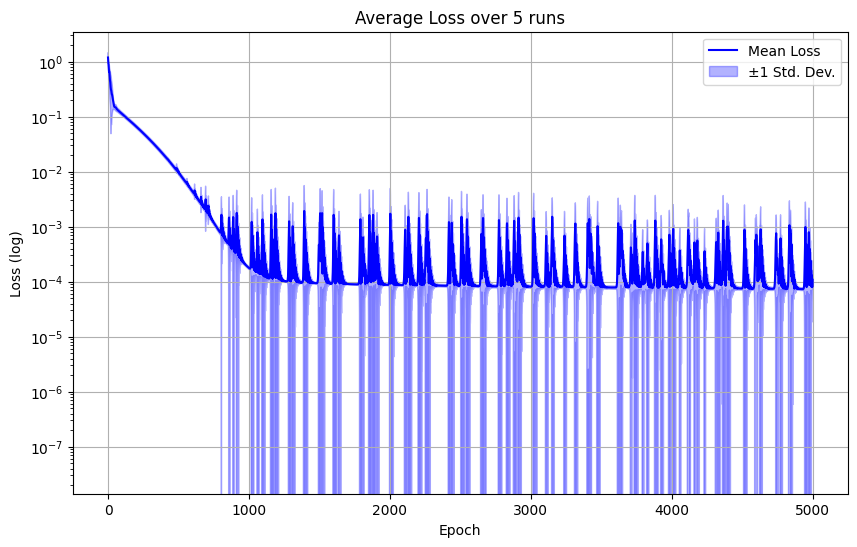

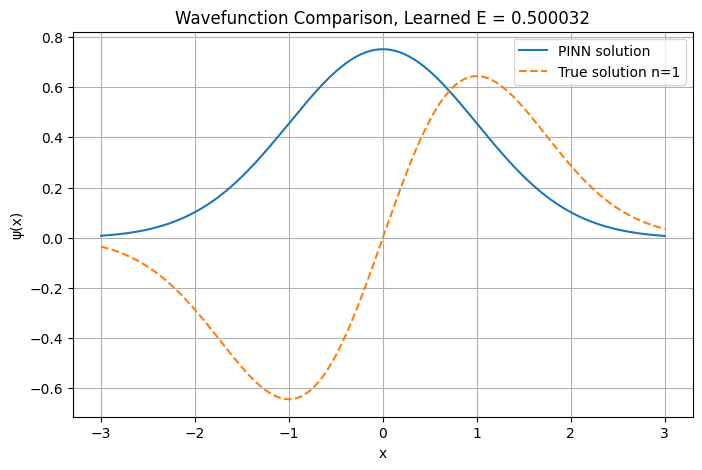

In [14]:
# Parameters you can easily tweak
epochs = 5000
runs = 5
L = 3.0
model = multi_run_plot(runs=runs, epochs=epochs, L=L)
compare_wavefunction(model, L=L, n=1)